<a href="https://colab.research.google.com/github/gagyeomkim/deepfake-defense-from-scratch/blob/seungeunlee/week09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from tqdm import tqdm
from IPython.display import HTML
from base64 import b64encode
import requests

In [2]:
# 1. 경로 설정
DATA_FOLDER = '/content/deepfake_data'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
TEST_FOLDER = 'test_videos'
FACE_DETECTION_FOLDER = '/content/cascades'

In [3]:
os.makedirs(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER), exist_ok=True)
os.makedirs(os.path.join(DATA_FOLDER, TEST_FOLDER), exist_ok=True)
os.makedirs(FACE_DETECTION_FOLDER, exist_ok=True)

In [4]:
# 2. Haar Cascade 파일 다운로드
cascades = ['haarcascade_frontalface_default.xml', 'haarcascade_eye.xml',
            'haarcascade_profileface.xml', 'haarcascade_smile.xml']
base_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/"

In [5]:
for c in cascades:
    r = requests.get(base_url + c)
    with open(os.path.join(FACE_DETECTION_FOLDER, c), 'wb') as f:
        f.write(r.content)
print("file prepared")

file prepared


In [6]:
def get_meta_from_json(path):
    json_path = os.path.join(DATA_FOLDER, path, 'metadata.json')
    if os.path.exists(json_path):
        df = pd.read_json(json_path).T
        return df
    else:
        print("file is not here.")
        return pd.DataFrame()

In [7]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return tt.T

In [8]:
def plot_count(feature, title, df, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(x=df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    g.set_title(f"Number and percentage of {title}")
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}%'.format(100*height/total), ha="center")
    plt.show()

In [9]:
class ObjectDetector():
    def __init__(self, object_cascade_path):
        self.objectCascade = cv.CascadeClassifier(object_cascade_path)

    def detect(self, image, scale_factor=1.3, min_neighbors=5, min_size=(20,20)):
        if image is None: return []
        # Haar Cascade 알고리즘으로 객체(얼굴 등)의 좌표를 찾습니다.
        rects = self.objectCascade.detectMultiScale(image, scaleFactor=scale_factor,
                                                    minNeighbors=min_neighbors, minSize=min_size)
        return rects

In [10]:
fd = ObjectDetector(os.path.join(FACE_DETECTION_FOLDER, 'haarcascade_frontalface_default.xml'))
ed = ObjectDetector(os.path.join(FACE_DETECTION_FOLDER, 'haarcascade_eye.xml'))
pd = ObjectDetector(os.path.join(FACE_DETECTION_FOLDER, 'haarcascade_profileface.xml'))

In [11]:
def detect_objects(image, scale_factor=1.3, min_neighbors=5, min_size=(50, 50)):
    if image is None: return
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # 1. 얼굴 탐지 (초록색)
    faces = fd.detect(image_gray, scale_factor, min_neighbors, min_size)
    for x, y, w, h in faces:
        cv.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)

    # 2. 눈 탐지 (빨간색 원)
    eyes = ed.detect(image_gray, scale_factor, min_neighbors, (int(min_size[0]/2), int(min_size[1]/2)))
    for x, y, w, h in eyes:
        cv.circle(image, (int(x+w/2), int(y+h/2)), (int((w+h)/4)), (0, 0, 255), 3)

    # 3. 결과 출력
    plt.figure(figsize=(10,10))
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [14]:
def extract_image_objects(video_file, video_set_folder=TRAIN_SAMPLE_FOLDER):
    video_path = os.path.join(DATA_FOLDER, video_set_folder, video_file)
    capture_image = cv.VideoCapture(video_path)
    ret, frame = capture_image.read()
    if ret:
        detect_objects(image=frame)
    else:
        print(f"file cannot be read : {video_path}")
    capture_image.release()

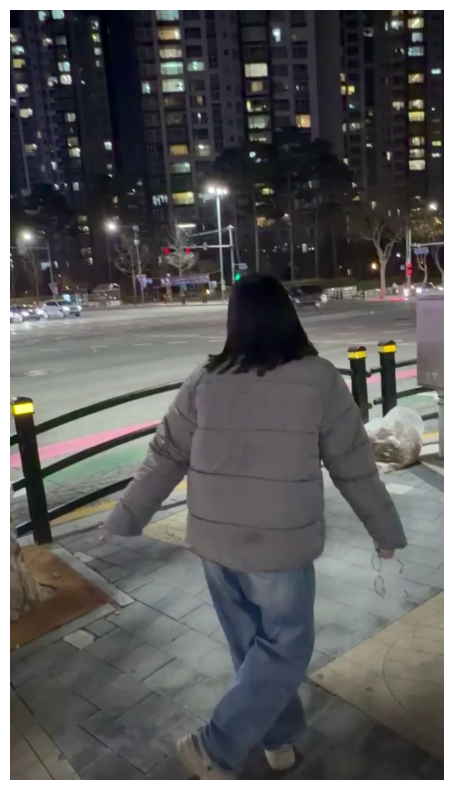

In [15]:
extract_image_objects('lsm.mp4')